# Tutorial 7: Expanding data dimension in RecordWriter and Pipeline

In many domains (especially medical imaging), multiple examples are sampled from the same data, we call it __data dimension expansion__. In this tutorial we will show you how to do data dimension expansion in FastEstimator.

In general, expanding data dimension can be achieved in both `RecordWriter` and `Pipeline`. Here are the differences:

* Expanding data in `RecordWriter` means occupying __more disk-space__, and the expanded samples are fixed during the training. The good thing is that it __saves preprocessing computation__ during training.

* Expanding data in `Pipeline` means expanded data can be different for every batch during training, the computation is done __in-memory__ therefore __no extra disk space__ is required. The drawback is that __additional computation__ is required.

In [3]:
# Import libraries
import fastestimator as fe
import numpy as np
import os
import matplotlib.pyplot as plt

## Step 1 - RecordWriter: expand data dimension and write it to the disk

In RecordWriter, for each 28x28 image, let's create 4 different 27x27 images from corners:

In [2]:
from fastestimator.dataset.mnist import load_data
from fastestimator.op import NumpyOp
from fastestimator.util import RecordWriter
from fastestimator.op.numpyop import ImageReader

# Load Mnist data
train_csv, eval_csv, data_path = load_data()

# Create a custom Numpy op to sample 4 images from the corners of each image
class SampleCorner(NumpyOp):
    def forward(self, data, state):
        x, y = data
        # we sample 4 27x27 images from the corners:
        x = np.array([x[:27, :27, :],
                      x[1:, 1:, :],
                      x[:27, 1:, :],
                      x[1:, :27, :]])
        y = np.array([y, y, y, y]) # the label does not change for each sampled image
        return x, y

# We insert this custom op in the ops list of RecordWriter.
# We have to specify expand_dims=True to allow data dimension expansion.
writer = RecordWriter(save_dir=os.path.join(data_path, "FEdata_replicate"),
                         train_data=train_csv,
                         validation_data=eval_csv,
                         ops=[ImageReader(inputs="x", outputs="x", parent_path=data_path, grey_scale=True),
                              SampleCorner(inputs=("x", "y"), outputs=("x", "y"))],
                         expand_dims=True)

## Step 2 - Pipeline: expand dimension on the fly

In the last step, we extracted 4 different 27x27 sub-images for each image. Now for each 27x27 image, let's randomly sub-sample two 20x20 images during the training:

In [4]:
from fastestimator.op.tensorop import Minmax
from fastestimator.op import TensorOp
import tensorflow as tf

# We create a custom op for random sampling 
class RandomSample(TensorOp):
    def forward(self, data, state):
        x, y = data
        # We randomly select the top-left point of our image for each sample (x and y coordinate)
        # It cannot be greater than 8 as we will sample a 20x20 image from a 27x27 one
        coord_x1_top_left = tf.random.uniform([], maxval=8, dtype=tf.int32)
        coord_y1_top_left = tf.random.uniform([], maxval=8, dtype=tf.int32)
        coord_x2_top_left = tf.random.uniform([], maxval=8, dtype=tf.int32)
        coord_y2_top_left = tf.random.uniform([], maxval=8, dtype=tf.int32)
        # We sample two 20x20 images with (x1,y1) and (x2,y2) top-left corner.
        x = tf.stack([x[coord_x1_top_left:coord_x1_top_left+20, coord_y1_top_left:coord_y1_top_left+20, :], 
                      x[coord_x2_top_left:coord_x2_top_left+20, coord_y2_top_left:coord_y2_top_left+20, :]])
        y = tf.stack([y, y]) # same label
        return x, y

# Create Pipeline with RandomSample op and expand_dims=True
pipeline = fe.Pipeline(data=writer,
                       batch_size=32,
                       ops=[Minmax(inputs="x", outputs="x"),
                            RandomSample(inputs=("x", "y"), outputs=("x", "y"))],
                       expand_dims=True)

## Step 3 - Check pipeline results...

In [5]:
# Let's check our pipeline ops results with show_results

result = pipeline.show_results()

x = result[0]["x"]
y = result[0]["y"]
print("shape of feature x is {}".format(x.shape))
print("shape of feature y is {}".format(y.shape))

FastEstimator: Saving tfrecord to /tmp/.fe/Mnist/FEdata_replicate
FastEstimator: Converting Train TFRecords 0.0%, Speed: 0.00 record/sec
FastEstimator: Converting Train TFRecords 5.0%, Speed: 10469.19 record/sec
FastEstimator: Converting Train TFRecords 10.0%, Speed: 10503.14 record/sec
FastEstimator: Converting Train TFRecords 15.0%, Speed: 10543.56 record/sec
FastEstimator: Converting Train TFRecords 20.0%, Speed: 10459.64 record/sec
FastEstimator: Converting Train TFRecords 25.0%, Speed: 10502.02 record/sec
FastEstimator: Converting Train TFRecords 30.0%, Speed: 10537.37 record/sec
FastEstimator: Converting Train TFRecords 35.0%, Speed: 10582.11 record/sec
FastEstimator: Converting Train TFRecords 40.0%, Speed: 10576.54 record/sec
FastEstimator: Converting Train TFRecords 45.0%, Speed: 10580.37 record/sec
FastEstimator: Converting Train TFRecords 50.0%, Speed: 10583.58 record/sec
FastEstimator: Converting Train TFRecords 55.0%, Speed: 10575.13 record/sec
FastEstimator: Converting Tr

## .... and visualize!

ground truth label is 2
ground truth label is 2
ground truth label is 5
ground truth label is 5


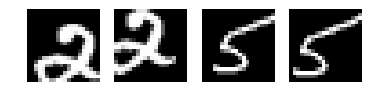

In [7]:
# Let's visualize the first 4 images (keeping the order) from our post-pipeline data:
fig, axes = plt.subplots(1, 4)
for i in range(4):
    axes[i].axis('off')
    axes[i].imshow(np.squeeze(x[i]), cmap='gray')
    print("ground truth label is {}".format(y[i]))

As we can see, each image is indeed generating two random patches.